In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
import PIL.Image as Image

from datetime import datetime
import antropy as ant
from scipy.stats import pearsonr

# tmp unused
from scipy.fft import fft, fftfreq
from scipy.signal import blackman, hamming, detrend
import scipy.signal as signal

In [71]:
# eeg segment
def eeg_segment(eeg_data, fs, seg_length, eeg_start_time):
    seg_points = seg_length * fs
    skip_second = (60 - int(eeg_start_time[-2:])) % 60
    print('skip_second', skip_second)
    eeg_data = eeg_data[:, skip_second*fs:]
    seg_num = eeg_data.shape[1] // seg_points
    eeg_data = eeg_data[:, 0:seg_points*seg_num]
    eeg_data_seg = eeg_data.reshape((eeg_data.shape[0], -1, seg_points))
    eeg_data_seg = eeg_data_seg.transpose(1,0,2)
    print('eeg_data_seg.shape', eeg_data_seg.shape)
    return eeg_data_seg

In [3]:
# Permutation entropy
def get_pe(eeg_data):
    pe = np.zeros((eeg_data.shape[0], eeg_data.shape[1]))
    for i in range(eeg_data.shape[0]):
        for j in range(eeg_data.shape[1]):
            pe[i,j] = ant.perm_entropy(eeg_data[i,j,:], normalize=True)
    print('pe.shape', pe.shape)
    for i in range(pe.shape[1]):
        plt.plot(pe[:,i])
    plt.show()
    return pe

In [4]:
# Approximate entropy
def get_ae(eeg_data):
    ae = np.zeros((eeg_data.shape[0], eeg_data.shape[1]))
    for i in range(eeg_data.shape[0]):
        for j in range(eeg_data.shape[1]):
            ae[i,j] = ant.app_entropy(eeg_data[i,j,:])
    print('ae.shape', ae.shape)
    for i in range(ae.shape[1]):
        plt.plot(ae[:,i])
    plt.show()
    return ae

In [5]:
# Sample entropy
def get_se(eeg_data):
    se = np.zeros((eeg_data.shape[0], eeg_data.shape[1]))
    for i in range(eeg_data.shape[0]):
        for j in range(eeg_data.shape[1]):
            se[i,j] = ant.sample_entropy(eeg_data[i,j,:])
    print('se.shape', se.shape)
    for i in range(se.shape[1]):
        plt.plot(se[:,i])
    plt.show()
    return se

In [6]:
# Lempel-Ziv complexity
def get_lzc(eeg_data):
    lzc = np.zeros((eeg_data.shape[0], eeg_data.shape[1]))
    for i in range(eeg_data.shape[0]):
        for j in range(eeg_data.shape[1]):
            x_bin = eeg_data[i,j,:].copy()*0
            thr = np.mean(eeg_data[i,j,:])
            x_bin[np.where(eeg_data[i,j,:] >= thr)] = 1
            lzc[i,j] = ant.lziv_complexity(x_bin, normalize=True)
    print('lzc.shape', lzc.shape)
    for i in range(lzc.shape[1]):
        plt.plot(lzc[:,i])
    plt.show()
    return lzc

In [7]:
# connectivity
def get_conn_svd(eeg_data, fs):
    svd = np.zeros((eeg_data.shape[0]))
    for i in range(eeg_data.shape[0]):
        eeg_tmp = eeg_data[i,:,:][np.newaxis, :, :]
        conn = mne.connectivity.spectral_connectivity(eeg_tmp, method='imcoh', sfreq=fs, 
                                    fmin=1, fmax=100, faverage=True, tmin=1, verbose='WARNING')
        conn = np.squeeze(conn[0])
        conn[np.triu_indices(eeg_tmp.shape[1], 1)] = conn[np.tril_indices(eeg_tmp.shape[1], -1)]
        conn[np.diag_indices(eeg_tmp.shape[1])] = 1
        s, _ = np.linalg.eig(conn)
        svd[i] = np.abs(np.max(s))
    return svd

In [8]:
def draw_scale(x, draw_max, draw_min):
    if x.ndim == 2:
        x_draw = np.mean(x, axis=1)
    elif x.ndim == 1:
        x_draw = x.copy()
    tmp_scale = (draw_max-draw_min) / (np.max(x_draw) - np.min(x_draw))
    x_draw *= tmp_scale
    x_draw -= (np.max(x_draw) - draw_max)
    return x_draw

In [9]:
path_root = '/Users/zhangchao/Downloads/data_tmp/0428'
fs = 1000

In [10]:
# get exp time
def get_exp(path_root):
    exp = os.listdir(path_root)
    exp.remove('.DS_Store')
    exp.remove('102044') # tmp (no xls)
    exp.sort()
    return exp

exp = get_exp(path_root)
exp

['093433', '111744', '115536', '123110']

In [11]:
# get eeg start time and end time
def get_eeg_time(path_root, exp):
    eeg_start_time = []
    eeg_end_time = []
    for i in range(len(exp)):
        with open('{}/{}/info.txt'.format(path_root, exp[i]), 'r') as f:
            for line in f.readlines():
                line = line.strip('\n')
                if '开始时间' in line:
                    eeg_start_time.append(line[-20:-1])
                    break
        with open('{}/{}/info.txt'.format(path_root, exp[i]), 'r') as f:
            for line in f.readlines():
                line = line.strip('\n')
                if '结束时间' in line:
                    eeg_end_time.append(line[-20:-1])
                    break
    return eeg_start_time, eeg_end_time
eeg_start_time, eeg_end_time = get_eeg_time(path_root, exp)
print('eeg_start_time', eeg_start_time)
print('eeg_end_time', eeg_end_time)

eeg_start_time ['2023-04-28 09:34:42', '2023-04-28 11:17:56', '2023-04-28 11:55:36', '2023-04-28 12:31:10']
eeg_end_time ['2023-04-28 09:58:22', '2023-04-28 11:38:57', '2023-04-28 12:12:48', '2023-04-28 13:00:50']


In [12]:
def csv2eeg(path_root, exp):
    path_tmp = '{}/{}/EP'.format(path_root, exp)
    print('path_tmp', path_tmp)
    if os.path.exists(path_tmp):
        csv_list = []
        for root, _, filenames in os.walk(path_tmp):
            for filename in fnmatch.filter(filenames, '*.csv'):
                csv_list.append(os.path.join(root, filename))
        csv_list.sort()
        print('csv_list', csv_list)
    else:
        return 0

    # read data of NeuraMatrix
    eeg = []
    for c in range(len(csv_list)):
        df = pd.read_csv('{}'.format(csv_list[c]), header=None)
        eeg.append(df[2])
    eeg = np.array(eeg)

    # 有可能ref电极没有贴好，这种情况下会耦合大量的工频干扰
    # eeg -= eeg[0,:]
    # eeg -= np.mean(eeg[[0,1,3,4], :], axis=0)

    return eeg

In [93]:
def draw_eeg_psd(raw, ch_names, exp):
    # fig, ax = plt.subplots(figsize=(6, 6))
    raw.plot(duration=50, remove_dc=False, scalings='auto')
    
    fig, ax = plt.subplots(figsize=(8, 4))
    raw.plot_psd(fmax=499, average=True, ax=ax)
    fig.savefig('./figs/4.28/exp{}_psd.png'.format(exp), dpi=300)

    for c in ch_names:
        fig, ax = plt.subplots(figsize=(8, 4))
        raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)
        # fig.savefig('./figs/4.24/exp{}_psd_ch{}.png'.format(i, c), dpi=300)

In [14]:
csv_path = '../csv_0428'

In [88]:
def process_xls(csv_path, exp_id):
    xls_info = {}
    csv_list = os.listdir(csv_path)
    csv_list.sort()
    print('csv_list', csv_list)

    if exp_id == 0:
        bis_line = 12
    else:
        bis_line = 13
    
    df = pd.read_excel('{}/{}'.format(csv_path, csv_list[exp_id]))
    print(df)

    xls_info['time_num'] = len(df.keys()) - 1
    print('time_num', xls_info['time_num'])

    xls_info['time_inject'] = 0
    xls_info['time_wake'] = 0
    xls_info['time_eyelash'] = 0
    for i in range(1, xls_info['time_num']):
        if '诱导给药' in str(df.iloc[14, i]):
            xls_info['time_inject'] = i
        if '唤醒' in str(df.iloc[14, i]):
            xls_info['time_wake'] = i
        if '睫毛反射恢复' in str(df.iloc[14, i]):
            xls_info['time_eyelash'] = i
    print('time_inject', xls_info['time_inject'])
    print('time_wake', xls_info['time_wake'])
    print('time_eyelash', xls_info['time_eyelash'])

    xls_info['bis_start'] = 0
    for i in range(1, xls_info['time_num']):
        # if not np.isnan(df.iloc[bis_line, i]):
        if not pd.isnull(df.iloc[bis_line, i]):
            xls_info['bis_start'] = i
            break
    print('bis_start', xls_info['bis_start']) 

    xls_info['eeg_start_idx'] = 0
    for key in df.keys():
        if key == eeg_start_time[exp_id][-8:-3]:
            break
        xls_info['eeg_start_idx'] += 1
    print('eeg_start_idx', xls_info['eeg_start_idx'])

    xls_info['eeg_end_idx'] = 0
    for key in df.keys():
        if key == eeg_end_time[exp_id][-8:-3]:
            break
        xls_info['eeg_end_idx'] += 1
    print('eeg_end_idx', xls_info['eeg_end_idx'])

    xls_info['heart_rate'] = np.array(list(map(int, df.iloc[0, 1:].tolist())))
    xls_info['pulse'] = np.array(list(map(int, df.iloc[1, 1:].tolist())))
    xls_info['bis'] = np.array(list(map(int, df.iloc[bis_line, xls_info['bis_start']:].tolist())))

    return xls_info

In [90]:
def draw_results(exp, xls_info, pe_draw, ae_draw, se_draw, lzc_draw, svd_draw):
    color_bkp = ['forestgreen', 'darkorange',  'dimgray',
                    'limegreen', 'royalblue', 'darkgrey', 'forestgreen', 'darkblue', 'purple']
    colors = ['darkgrey', 'k', 'firebrick', 'forestgreen', 'darkorange', 'royalblue', 'purple','limegreen']

    plt.figure(figsize=(12,4))
    plt.plot(np.arange(xls_info['time_num']), xls_info['heart_rate'], label='Heart rate', color=colors[0], lw=2)

    plt.plot(np.arange(xls_info['time_num']), xls_info['pulse'], label='Pulse', color=colors[1], lw=2)

    bis_x = np.arange(xls_info['time_num']-(xls_info['bis_start']-1))+(xls_info['bis_start']-1)
    # 最后一个bis=0没有画出来
    plt.plot(bis_x[0:-1], xls_info['bis'][0:-1], label='BIS', color=colors[2], lw=2)

    eeg_feature_x = np.arange(xls_info['eeg_end_idx']-xls_info['eeg_start_idx']-1)+(xls_info['eeg_start_idx']-1)
    plt.plot(eeg_feature_x, pe_draw, label='PE', color=colors[3], lw=1)

    plt.plot(eeg_feature_x, ae_draw, label='AE', color=colors[4], lw=1)

    plt.plot(eeg_feature_x, se_draw, label='SE', color=colors[5], lw=1)

    plt.plot(eeg_feature_x, lzc_draw, label='LZC', color=colors[6], lw=1)

    plt.plot(eeg_feature_x, svd_draw, label='SVD', color=colors[7], lw=1)

    plt.axvline(xls_info['time_inject'], label='Injection', color='r', ls='dashed', lw=2)
    plt.axvline(xls_info['time_wake'], label='Wake', color='b', ls='dashed', lw=2)

    plt.ylim(np.min(xls_info['heart_rate'])-5, np.max(xls_info['heart_rate'])+5)
    plt.xticks(font={'family':'Arial', 'size':16})
    plt.yticks(font={'family':'Arial', 'size':16})
    plt.xlabel('Time (minute)', font={'family':'Arial', 'size':20})
    plt.ylabel('Values', font={'family':'Arial', 'size':20})
    plt.title('Exp_{}'.format(exp), font={'family':'Arial', 'size':24})

    plt.legend(loc=(1.05, 0), edgecolor='k', prop={'family':'Arial', 'size':14})
    plt.savefig('figs/4.28/features_exp_{}.png'.format(exp), dpi=300, bbox_inches='tight')
    plt.show()
    
    corr_eeg_features = np.zeros((2, 6))
    p_eeg_features = np.zeros((2, 6))
    corr_eeg_features[0, 0], p_eeg_features[0, 0] = pearsonr(xls_info['bis'], xls_info['heart_rate'][bis_x])
    corr_eeg_features[0, 1], p_eeg_features[0, 1] = pearsonr(pe_draw, xls_info['heart_rate'][eeg_feature_x])
    corr_eeg_features[0, 2], p_eeg_features[0, 2] = pearsonr(ae_draw, xls_info['heart_rate'][eeg_feature_x])
    corr_eeg_features[0, 3], p_eeg_features[0, 3] = pearsonr(se_draw, xls_info['heart_rate'][eeg_feature_x])
    corr_eeg_features[0, 4], p_eeg_features[0, 4] = pearsonr(lzc_draw, xls_info['heart_rate'][eeg_feature_x])
    corr_eeg_features[0, 5], p_eeg_features[0, 5] = pearsonr(svd_draw, xls_info['heart_rate'][eeg_feature_x])

    corr_eeg_features[1, 0], p_eeg_features[1, 0] = pearsonr(xls_info['bis'], xls_info['pulse'][bis_x])
    corr_eeg_features[1, 1], p_eeg_features[1, 1] = pearsonr(pe_draw, xls_info['pulse'][eeg_feature_x])
    corr_eeg_features[1, 2], p_eeg_features[1, 2] = pearsonr(ae_draw, xls_info['pulse'][eeg_feature_x])
    corr_eeg_features[1, 3], p_eeg_features[1, 3] = pearsonr(se_draw, xls_info['pulse'][eeg_feature_x])
    corr_eeg_features[1, 4], p_eeg_features[1, 4] = pearsonr(lzc_draw, xls_info['pulse'][eeg_feature_x])
    corr_eeg_features[1, 5], p_eeg_features[1, 5] = pearsonr(svd_draw, xls_info['pulse'][eeg_feature_x])

    color = ['firebrick', 'royalblue']
    ecolor = ['k', 'k']
    width = 0.3
    
    x_label = ['BIS', 'PE', 'AE', 'SE', 'LZC', 'SVD']
    x_bar = np.arange(len(x_label))

    plt.figure(figsize=(6, 4))
    plt.bar(x_bar-width-0.05, corr_eeg_features[0,:], label='Corr vs Heate rate',
            width=width, edgecolor=ecolor[0], color=color[0], alpha=1, zorder=100)
    plt.bar(x_bar+0.05, corr_eeg_features[1,:], label='Corr vs Pulse',
            width=width, edgecolor=ecolor[1], color=color[1], alpha=1, zorder=100)

    for i in range(p_eeg_features.shape[0]):
        for j in range(p_eeg_features.shape[1]):
            if p_eeg_features[i,j] < 0.01:
                print(p_eeg_features[i,j])
                if i==0:
                    x_tmp = j - width - 0.24
                else:
                    x_tmp = j - 0.1
                if corr_eeg_features[i,j] > 0:
                    y_tmp = corr_eeg_features[i,j]
                else:
                    y_tmp = 0
                plt.annotate(r'$**$', xy=(x_tmp, y_tmp), fontsize=16, color='r')
            elif p_eeg_features[i,j] < 0.05:
                print(p_eeg_features[i,j])
                if i==0:
                    x_tmp = j - width - 0.14
                else:
                    x_tmp = j - 0.04
                if corr_eeg_features[i,j] > 0:
                    y_tmp = corr_eeg_features[i,j]
                else:
                    y_tmp = 0
                plt.annotate(r'$*$', xy=(x_tmp, y_tmp), fontsize=16, color='r')

    plt.bar(x_bar-width/2, np.zeros(x_bar.shape[0]), tick_label=x_label)
    plt.xticks(fontproperties = 'Arial', size = 14)
    plt.yticks(fontproperties = 'Arial', size = 14)
    plt.ylabel('Corr', font={'family':'Arial', 'size':16})
    plt.xlabel('Features', font={'family':'Arial', 'size':16})
    
    plt.ylim(np.min(corr_eeg_features) - 0.05, np.max(corr_eeg_features) + 0.05)
    plt.legend(ncol=1, edgecolor='k', prop={'family':'Arial', 'size':14})
    # plt.grid(zorder=0)
    plt.tight_layout()
    plt.savefig('figs/4.28/corr_exp_{}.png'.format(exp), dpi=300, bbox_inches='tight')
    plt.show()


path_tmp /Users/zhangchao/Downloads/data_tmp/0428/123110/EP
csv_list ['/Users/zhangchao/Downloads/data_tmp/0428/123110/EP/CA_46_B1_BF_97_28-1.csv', '/Users/zhangchao/Downloads/data_tmp/0428/123110/EP/CA_46_B1_BF_97_28-2.csv', '/Users/zhangchao/Downloads/data_tmp/0428/123110/EP/CA_46_B1_BF_97_28-3.csv', '/Users/zhangchao/Downloads/data_tmp/0428/123110/EP/CA_46_B1_BF_97_28-4.csv', '/Users/zhangchao/Downloads/data_tmp/0428/123110/EP/CA_46_B1_BF_97_28-5.csv']
eeg.shape (5, 1765871)
duration(s): 1765.871
<Info | 7 non-empty values
 bads: []
 ch_names: EEG0, EEG1, EEG2, EEG3, EEG4
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 1000.0 Hz
>
Creating RawArray with float64 data, n_channels=5, n_times=1765871
    Range : 0 ... 1765870 =      0.000 ...  1765.870 secs
Ready.
Using matplotlib as 2D backend.


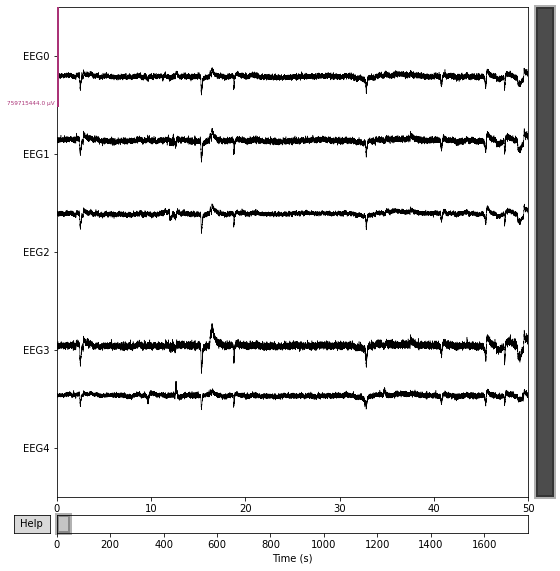

Effective window size : 2.048 (s)


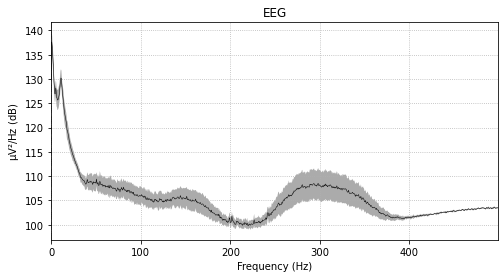

Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/t1/8nly90wx3dgbs59hy6n2shvw0000gn/T/ipykernel_14979/1807302417.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)


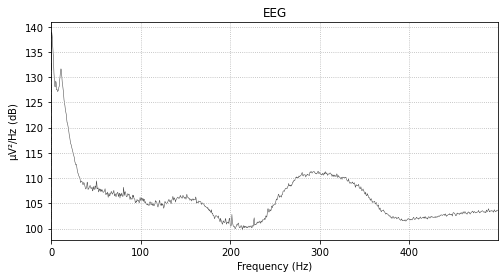

Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/t1/8nly90wx3dgbs59hy6n2shvw0000gn/T/ipykernel_14979/1807302417.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)


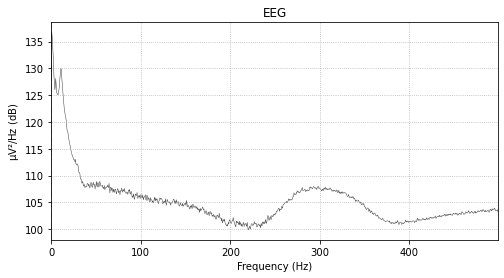

Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/t1/8nly90wx3dgbs59hy6n2shvw0000gn/T/ipykernel_14979/1807302417.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)


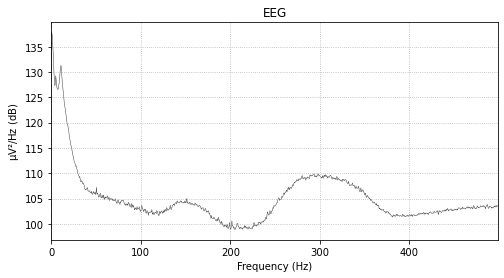

Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/t1/8nly90wx3dgbs59hy6n2shvw0000gn/T/ipykernel_14979/1807302417.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)


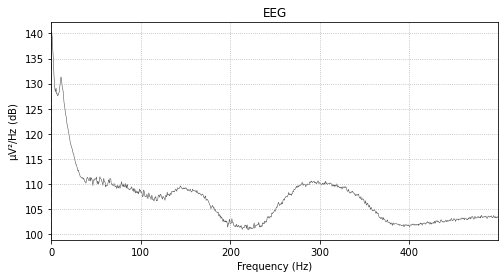

Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/t1/8nly90wx3dgbs59hy6n2shvw0000gn/T/ipykernel_14979/1807302417.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=499, average=False, picks=[c], ax=ax)


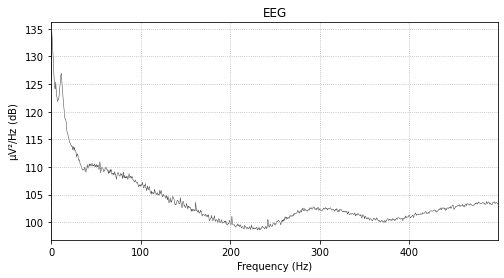

csv_list ['093433_上杉佳10772010.xls', '111744_杨玉娟10117424.xls', '115536_邹琦飞10381836.xls', '123110_刘宏11299760.xls']
       名称  12:25  12:30  12:31  12:32         12:33  12:34  12:35  12:36  \
0      心率   55.0   53.0   53.0   52.0            56   63.0   56.0   59.0   
1   PULSE   55.0   53.0   53.0   52.0            56   63.0   56.0   59.0   
2   中心静脉压    NaN    0.0    0.0    0.0             0    0.0    0.0    0.0   
3      呼吸    NaN    0.0    0.0    0.0             0    0.0    0.0    0.0   
4    SpO2   99.0   98.0   98.0  100.0           100  100.0   99.0   94.0   
5   ETCO2    NaN    0.0    0.0    0.0             0    0.0    0.0    0.0   
6    FiO2    NaN    0.0    0.0    0.0             0    0.0    0.0    0.0   
7   无创收缩压  145.0  146.0  146.0  146.0           148  148.0  148.0  117.0   
8   无创舒张压   85.0   86.0   86.0   86.0            85   85.0   85.0   69.0   
9      体温    NaN    0.0    0.0    0.0             0    0.0    0.0    0.0   
10  动脉收缩压    NaN    0.0    0.0    0.0             0

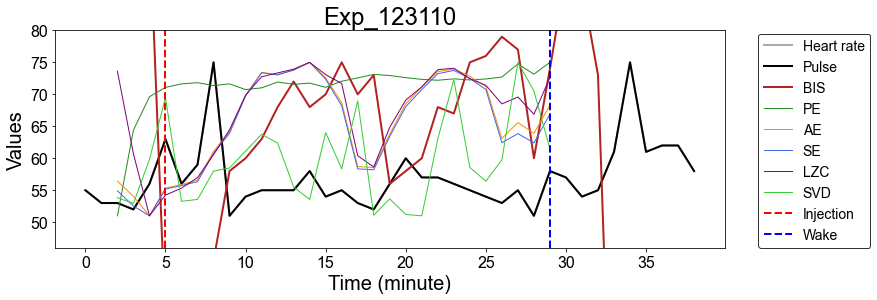

7.813994048702399e-05
7.813994048702399e-05


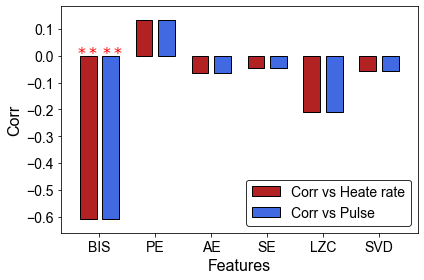

In [95]:
data_info = {}

# for i in range(len(exp)):
for i in range(3,4):
    eeg = csv2eeg(path_root, exp[i])

    print('eeg.shape', eeg.shape)
    print('duration(s):', eeg.shape[1]/fs)
    data_info['exp{}_duration'.format(i)] = eeg.shape[1]/fs
    tmp = datetime.strptime(eeg_end_time[i], '%Y-%m-%d %H:%M:%S') - datetime.strptime(eeg_start_time[i], '%Y-%m-%d %H:%M:%S')
    data_info['exp{}_pack_loss'.format(i)] = tmp.seconds - eeg.shape[1]/fs

    ch_num = eeg.shape[0]
    # for mne object
    ch_names = ['EEG{}'.format(j) for j in range(ch_num)]
    ch_types = ['eeg' for i in range(ch_num)]
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=fs)
    print(info)

    data_info['exp{}_chnum'.format(i)] = eeg.shape[0]
    data_info['exp{}_filename'.format(i)] = exp[i]

    my_raw = mne.io.RawArray(eeg, info)
    draw_eeg_psd(my_raw, ch_names, exp[i])

    xls_info = process_xls(csv_path, exp_id=i)

    eeg_data = eeg_segment(eeg, fs, seg_length=60, eeg_start_time=eeg_start_time[i])

    pe = get_pe(eeg_data)
    pe_draw = draw_scale(x=pe, draw_max=np.max(xls_info['heart_rate']), draw_min=np.min(xls_info['heart_rate']))

    ae = get_ae(eeg_data)
    ae_draw = draw_scale(x=ae, draw_max=np.max(xls_info['heart_rate']), draw_min=np.min(xls_info['heart_rate']))

    se = get_se(eeg_data)
    se_draw = draw_scale(x=se, draw_max=np.max(xls_info['heart_rate']), draw_min=np.min(xls_info['heart_rate']))

    lzc = get_lzc(eeg_data)
    lzc_draw = draw_scale(x=lzc, draw_max=np.max(xls_info['heart_rate']), draw_min=np.min(xls_info['heart_rate']))

    svd = get_conn_svd(eeg_data, fs)
    svd_draw = draw_scale(x=svd, draw_max=np.max(xls_info['heart_rate']), draw_min=np.min(xls_info['heart_rate']))

    draw_results(exp[i], xls_info, pe_draw, ae_draw, se_draw, lzc_draw, svd_draw)
    

In [58]:
xls_info

{'time_num': 22,
 'time_inject': 1,
 'time_wake': 0,
 'time_eyelash': 0,
 'bis_start': 1,
 'eeg_start_idx': 2,
 'eeg_end_idx': 19,
 'heart_rate': array([ 93,  93,  93,  96,  93,  95,  94,  97,  97,  94,  91,  93,  92,
         93,  92,  96,  92,  91,  99, 100,   0,   0]),
 'pulse': array([ 93,  93,  93,  96,  93,  95,  94,  97,  97,  94,  91,  93,  92,
         93,  92,  96,  92,  91,  99, 100,   0,   0]),
 'bis': array([41, 44, 66, 45, 41, 44, 62, 66, 67, 60, 66, 46, 41, 57, 66, 72, 74,
        73, 80, 82, 82,  0])}

In [61]:
eeg_start_time

['2023-04-28 09:34:42',
 '2023-04-28 11:17:56',
 '2023-04-28 11:55:36',
 '2023-04-28 12:31:10']

In [63]:
eeg_end_time

['2023-04-28 09:58:22',
 '2023-04-28 11:38:57',
 '2023-04-28 12:12:48',
 '2023-04-28 13:00:50']

In [59]:
data_info

{'exp2_duration': 1023.799,
 'exp2_pack_loss': 8.201000000000022,
 'exp2_chnum': 5,
 'exp2_filename': '115536'}

In [77]:
csv_list = os.listdir(csv_path)
csv_list.sort()
print('csv_list', csv_list)
df = pd.read_excel('{}/{}'.format(csv_path, csv_list[2]))
# df = df.T
# df.drop([0])
df

csv_list ['093433_上杉佳10772010.xls', '111744_杨玉娟10117424.xls', '115536_邹琦飞10381836.xls', '123110_刘宏11299760.xls']


,名称,11:54,11:55,11:56,11:57,11:58,11:59,12:00,12:01,12:02,...,12:06,12:07,12:08,12:09,12:10,12:11,12:12,12:13,12:14,12:15
0,心率,93,93,93.0,96.0,93.0,95.0,94.0,97.0,97,...,92.0,93,92.0,96.0,92.0,91,99.0,100.0,0.0,0.0
1,PULSE,93,93,93.0,96.0,93.0,95.0,94.0,97.0,97,...,92.0,93,92.0,96.0,92.0,91,99.0,100.0,0.0,0.0
2,中心静脉压,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,呼吸,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0.0,0.0,0,13.0,0.0,0.0,0.0
4,SpO2,100,100,99.0,99.0,99.0,100.0,99.0,99.0,99,...,98.0,100,99.0,96.0,99.0,99,100.0,99.0,0.0,0.0
5,ETCO2,0,9,10.0,9.0,11.0,13.0,9.0,11.0,11,...,5.0,15,12.0,8.0,10.0,14,12.0,12.0,0.0,0.0
6,FiO2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
7,无创收缩压,98,98,98.0,110.0,110.0,110.0,115.0,115.0,115,...,122.0,122,122.0,116.0,116.0,116,114.0,114.0,114.0,114.0
8,无创舒张压,60,60,60.0,72.0,72.0,72.0,74.0,74.0,74,...,84.0,84,84.0,75.0,75.0,75,71.0,71.0,71.0,71.0
9,体温,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [83]:
df.iloc[14, 4]

nan

In [25]:
csv_list = os.listdir(csv_path)
csv_list.sort()
print('csv_list', csv_list)
df = pd.read_excel('{}/{}'.format(csv_path, csv_list[3]))
# df = df.T
# df.drop([0])
df

csv_list ['093433_上杉佳10772010.xls', '111744_杨玉娟10117424.xls', '115536_邹琦飞10381836.xls', '123110_刘宏11299760.xls']


,名称,12:25,12:30,12:31,12:32,12:33,12:34,12:35,12:36,12:37,...,12:58,12:59,13:00,13:01,13:02,13:03,13:04,13:05,13:06,13:07
0,心率,55.0,53.0,53.0,52.0,56,63.0,56.0,59.0,75.0,...,58.0,57.0,54.0,55.0,61.0,75.0,61.0,62.0,62.0,58.0
1,PULSE,55.0,53.0,53.0,52.0,56,63.0,56.0,59.0,75.0,...,58.0,57.0,54.0,55.0,61.0,75.0,61.0,62.0,62.0,58.0
2,中心静脉压,NaN,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,呼吸,NaN,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SpO2,99.0,98.0,98.0,100.0,100,100.0,99.0,94.0,86.0,...,100.0,100.0,100.0,100.0,98.0,93.0,95.0,95.0,95.0,96.0
5,ETCO2,NaN,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,FiO2,NaN,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,无创收缩压,145.0,146.0,146.0,146.0,148,148.0,148.0,117.0,117.0,...,129.0,129.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0
8,无创舒张压,85.0,86.0,86.0,86.0,85,85.0,85.0,69.0,69.0,...,73.0,73.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0
9,体温,NaN,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:

eeg_data = eeg_segment(eeg, fs, seg_length=60)


eeg_data_seg.shape (23, 5, 60000)


pe.shape (23, 5)


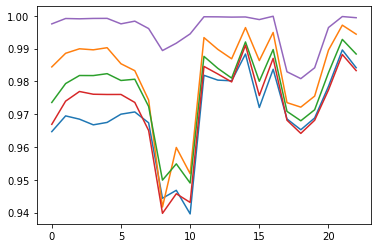

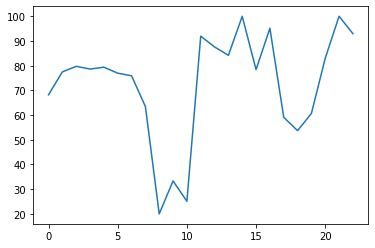

In [230]:

pe = get_pe(eeg_data)
pe_draw = draw_scale(x=pe, draw_max=100, draw_min=20)
plt.plot(pe_draw)
plt.show()

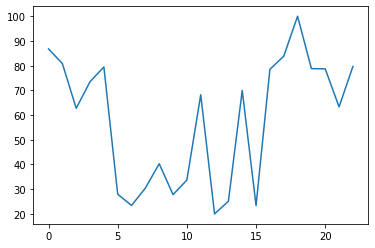

In [232]:
ae_draw = draw_scale(x=ae, draw_max=100, draw_min=20)
plt.plot(ae_draw)
plt.show()

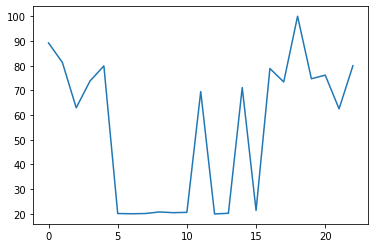

In [233]:


# se_draw = np.mean(se, axis=1)
# tmp_scale = (100-20) / (np.max(se_draw) - np.min(se_draw))
# se_draw *= tmp_scale
# se_draw -= (np.max(se_draw) - 100)
se_draw = draw_scale(x=se, draw_max=100, draw_min=20)

plt.plot(se_draw)
plt.show()

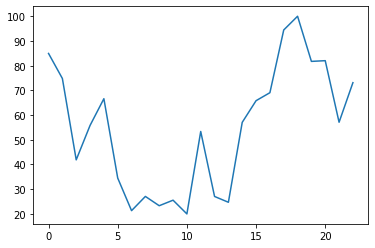

In [234]:


lzc_draw = draw_scale(x=lzc, draw_max=100, draw_min=20)

plt.plot(lzc_draw)
plt.show()

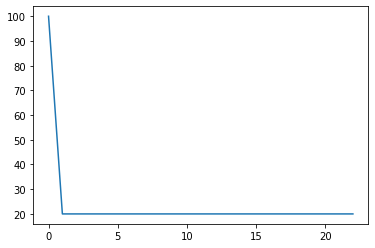

In [268]:


# svd_draw = draw_scale(x=svd, draw_max=100, draw_min=20)

plt.plot(svd_draw)
plt.show()

In [79]:
data_info

{'exp1_duration': 1408.704, 'exp1_chnum': 5, 'exp1_filename': '3'}

In [78]:
eeg.shape

(5, 1408704)

In [ ]:
my_raw.plot(start=1, duration=1, remove_dc=False, scalings='auto')